# Lista 03

Artificial neural networks for image classification.

In [6]:
READ_DATASETS = False

## Common Functions

In [7]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Plotting

In [8]:
def create_image_panel(images, labels, cols=3, title=None):

    if len(images) != len(labels):
        raise ValueError("Number of images and labels must be equal.")

    rows = int(len(images) / cols) + (len(images) % cols > 0)
    fig, axes = plt.subplots(rows, cols, figsize=(5, rows * 2))

    for i in range(rows*cols):
        row, col = divmod(i, cols)
        if rows == 1:
            axs = axes[col]
        else:
            axs = axes[row, col]
        if i < len(images):
            axs.imshow(images[i])
            axs.set_title(labels[i])
        axs.axis('off')

    if title is not None:
        fig.suptitle(title, fontsize=12)
    plt.tight_layout()
    return fig

In [9]:
colors = [
    "#22223B",
    "#4A4E69",
    "#0B3954",
    "#087E8B",
    "#C81D25",
    "#FF5A5F",
    "#11270b",
    "#3c5a14",
]

In [10]:
def create_bar_plot(labels, values, axis_label=None, title=None,
                    values2=None, axis2_label=None,
                    horizontal=False):

    if len(values) != len(labels):
        raise ValueError("Number of values and labels must be equal.")
    if horizontal and values2 is not None:
        raise ValueError("Cannot have twin axis in a horizontal bar plot.")

    fig, ax1 = plt.subplots(figsize=(5, 3))

    color = colors[0]
    color2 = colors[1]
    if values2 is None:
        width = 0.8,
        delta = 0.
    else:
        width = 0.4
        delta = width/2.

    if horizontal:
        ax1.barh(
            labels,
            values,
            color=color,
        )
    else:
        ax1.bar(
            np.arange(len(labels)) - delta,
            values,
            color=color,
            width=width,
            align="center",
        )

    if values2 is not None:
        ax2 = ax1.twinx()
        ax2.bar(
            np.arange(len(labels)) + delta,
            values2,
            color=color2,
            width=width,
            align="center",
        )

    if not horizontal:
        ax1.set_xticks(np.arange(len(labels)))
        ax1.set_xticklabels(labels, rotation=0)
    if axis_label is not None:
        if horizontal:
            ax1.set_xlabel(axis_label, color=color)
        else:
            ax1.set_ylabel(axis_label, color=color)
    if axis2_label is not None:
        ax2.set_ylabel(axis2_label, color=color2)

    if title is not None:
        plt.title(title)
    plt.tight_layout()
    return fig

### Model History

In [11]:
def plot_metrics(history, metrics = ['acc', 'loss']):
    best = np.argmax(history['val_acc'])
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(
            range(len(history[metric])),
            history[metric],
            color=colors[2],
            label='Train')
        plt.plot(
            range(len(history[metric])),
            history['val_'+metric],
            color=colors[3],
            label='Val')
        plt.plot(best,
                 history['val_'+metric][best],
                 marker='o',
                 color='red')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()
        plt.tight_layout()

### Confusion Matrix

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

In [13]:
def print_table(data, horizontal_lines=[1]):
    column_widths = [max(len(str(item)) for item in column)
                     for column in zip(*data)]
    format_string = " | ".join(f"{{:<{width}}}" for width in column_widths)
    for i, row in enumerate(data):
        if i in horizontal_lines:
            print("-" * len("| " + format_string.format(*row) + " |"))
        print("| " + format_string.format(*row) + " |")

In [14]:
def model_summary(X_test, y_test, y_pred, labels, description, filename):

    def _model_summary_table(y_pred, y_test, labels):
        results = [("Class", "Accuracy", "Recall")]
        acc = accuracy_score(y_test, y_pred)
        balanced_accuracy = recall_score(y_test, y_pred, average="macro")
        results.append((
            "All",
            f"{acc:0.4f}",
            f"{balanced_accuracy:0.4f}"))
        recall = recall_score(y_test, y_pred, average=None)
        for i, (label, rec) in enumerate(zip(labels, recall)):
            acc = accuracy_score(y_test[y_test==i], y_pred[y_test==i])
            results.append((
                label,
                f"{acc:0.4f}",
                f"{rec:0.4f}"))
        print_table(results, horizontal_lines=[1, 2])


    def _model_summary_confusion_matrix(y_test, y_pred, labels, description, filename):
        conf_matrix = confusion_matrix(y_test, y_pred)
        conf_matrix_disp = ConfusionMatrixDisplay(
            confusion_matrix=conf_matrix, display_labels=labels
        )
        _, ax = plt.subplots(figsize=(8, 6))
        plt.title(f"{description} Confusion Matrix")
        conf_matrix_disp.plot(ax=ax, xticks_rotation=25)
        conf_matrix_disp.im_.set_clim(0, 600)
        plt.savefig(f"report/png/{filename}", bbox_inches="tight")
        plt.show()

    _model_summary_table(y_pred, y_test, labels)
    _model_summary_confusion_matrix(
        y_pred, y_test, labels, description, filename)

## Database

 https://medmnist.com/

In [15]:
from medmnist import BloodMNIST

image_size=28
if READ_DATASETS:
    train_dataset = BloodMNIST(split="train", download=True, size=image_size)
    val_dataset = BloodMNIST(split="val", download=True, size=image_size)
    test_dataset = BloodMNIST(split="test", download=True, size=image_size)

    _ = joblib.dump(train_dataset, f"data/train_dataset_{image_size}.sav")
    _ = joblib.dump(val_dataset, f"data/val_dataset_{image_size}.sav")
    _ = joblib.dump(test_dataset, f"data/test_dataset_{image_size}.sav")
else:
    train_dataset = joblib.load(f"data/train_dataset_{image_size}.sav")
    val_dataset = joblib.load(f"data/val_dataset_{image_size}.sav")
    test_dataset = joblib.load(f"data/test_dataset_{image_size}.sav")

In [16]:
train_dataset

Dataset BloodMNIST of size 28 (bloodmnist)
    Number of datapoints: 11959
    Root location: C:\Users\tiago.LENOVO-I7\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28

In [17]:
labels = [
    'basophil',
    'eosinophil',
    'erythroblast',
    'immature granulocytes',
    'lymphocyte',
    'monocyte',
    'neutrophil',
    'platelet'
]

In [18]:
X_train = train_dataset.imgs[:] / 255.
y_train = train_dataset.labels[:,0]

X_val = val_dataset.imgs[:] / 255.
y_val = val_dataset.labels[:,0]

X_test = test_dataset.imgs[:] / 255.
y_test = test_dataset.labels[:,0]

In [19]:
print(f"Train data: {X_train.shape}")
print(f"Validation data: {X_val.shape}")
print(f"Test data: {X_test.shape}")

Train data: (11959, 28, 28, 3)
Validation data: (1712, 28, 28, 3)
Test data: (3421, 28, 28, 3)


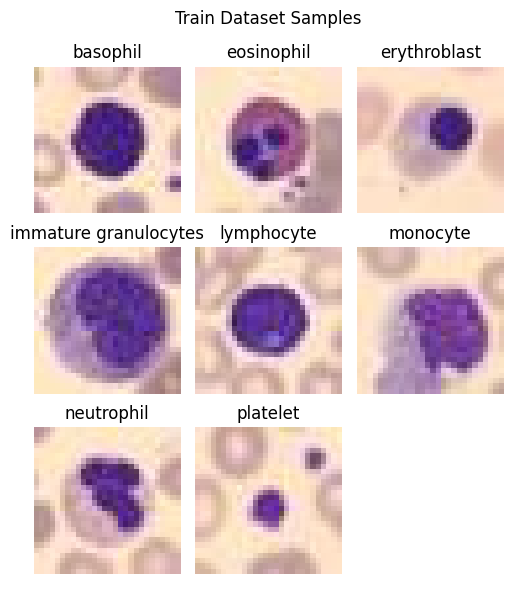

In [20]:
images = []
for i in range(len(labels)):
    images.append(X_train[y_train==i][0])

image_panel = create_image_panel(images, labels, title="Train Dataset Samples")
plt.show(image_panel)

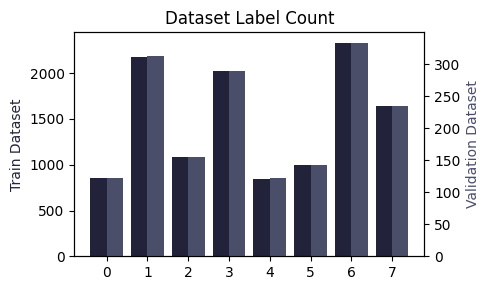

In [21]:
label_count_train = [sum(y_train==i) for i in range(len(labels))]
label_count_val = [sum(y_val==i) for i in range(len(labels))]
create_bar_plot(
    labels=range(len(labels)),
    values=label_count_train,
    axis_label="Train Dataset",
    values2=label_count_val,
    axis2_label="Validation Dataset",
    title="Dataset Label Count",
)
plt.show()

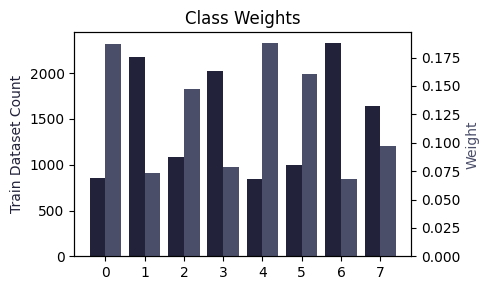

In [22]:
class_weight = {i:1 / sum(y_train==i) for i in range(len(labels))}
total_weights = sum(class_weight.values())
for k,v in class_weight.items():
    class_weight[k] = v / total_weights

create_bar_plot(
    labels=range(len(labels)),
    values=label_count_train,
    axis_label="Train Dataset Count",
    values2=class_weight.values(),
    axis2_label="Weight",
    title="Class Weights",
)
plt.show()

## 'ResNet-like' CNN

In [23]:
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold


In [24]:
def single_block(x, n_filters, n_layers=2, activation="relu"):
    x_skip = x

    x = keras.layers.Conv2D(n_filters, (3,3), padding = 'same', strides = (2,2))(x)
    x = keras.layers.BatchNormalization(axis=3)(x)

    for _ in range(n_layers-1):
        x = keras.layers.Activation(activation)(x)
        x = keras.layers.Conv2D(n_filters, (3,3), padding = 'same')(x)
        x = keras.layers.BatchNormalization(axis=3)(x)

    x_skip = keras.layers.Conv2D(n_filters, (1,1), strides = (2,2))(x_skip)
    x = keras.layers.Add()([x, x_skip])
    x = keras.layers.Activation(activation)(x)
    return x

In [25]:
def make_ResNet(initial_kernel=(7,7), initial_n_filters=64,
                initial_max_pooling=False,
                final_dense=False,
                n_res_blocks=2, n_layers_per_block=3,
                optimizer="adam", activation="relu", use_augmentation=False):

    x_input = keras.layers.Input(shape=(image_size,image_size,3))
    pad = ((int(initial_kernel[0]/2),
            int(initial_kernel[1]/2)))
    x = keras.layers.ZeroPadding2D(pad)(x_input)

    if use_augmentation:
        x = keras.layers.RandomFlip("horizontal_and_vertical")(x)
        x = keras.layers.RandomRotation(0.2)(x)

    x = keras.layers.Conv2D(initial_n_filters, kernel_size=initial_kernel, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(activation)(x)

    if initial_max_pooling:
        x = keras.layers.MaxPool2D(pool_size=3, padding='same')(x)

    n_filters = initial_n_filters
    for i in range(n_res_blocks):
        n_filters = n_filters*2
        x = single_block(x,
                         n_filters=n_filters,
                         n_layers=n_layers_per_block,
                         activation=activation)

    x = keras.layers.GlobalAveragePooling2D()(x)

    if final_dense:
        x = keras.layers.Dense(n_filters, activation = activation)(x)

    x = keras.layers.Dense(len(labels), activation = 'softmax')(x)
    model = keras.models.Model(inputs = x_input, outputs = x)

    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(),
        optimizer=optimizer,
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")])

    return model

In [26]:
def plot_model(model, name, dpi=75):
    name = f'./report/png/{name}.png'
    return keras.utils.plot_model(
        model=model,
        to_file=name,
        show_shapes=True,
        dpi=dpi,
        show_layer_activations=True)

In [27]:
def save_model(name, model):
    _ = joblib.dump(model, f"models/{name}.sav")
    model.model().save(f"models/{name}.keras")

def load_model(name, keras_model=False):
    if keras_model:
        model = keras.models.load_model(f"models/{name}.keras")
    else:
        model = joblib.load(f"models/{name}.sav")
    return model

In [28]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_acc",
        patience=10,
        start_from_epoch=10,
        mode='max',
        restore_best_weights=True
    ),
]

In [29]:
params = {
    'initial_kernel': [(3,3),(5,5),(7,7)],
    'initial_n_filters': [2**i for i in range(5,9)],
    'initial_max_pooling': [True, False],
    'final_dense': [True, False],
    'n_res_blocks': [2, 3, 4, 5],
    'n_layers_per_block': [2, 3, 4],
    'optimizer': ['SGD', 'RMSprop', 'Adam'],
    'activation': ['relu', 'tanh'],
    'use_augmentation': [False, True],
    'batch_size': [2**i for i in range(4,8)],
    'class_weight':[None, class_weight]
}
params

{'initial_kernel': [(3, 3), (5, 5), (7, 7)],
 'initial_n_filters': [32, 64, 128, 256],
 'initial_max_pooling': [True, False],
 'final_dense': [True, False],
 'n_res_blocks': [2, 3, 4, 5],
 'n_layers_per_block': [2, 3, 4],
 'optimizer': ['SGD', 'RMSprop', 'Adam'],
 'activation': ['relu', 'tanh'],
 'use_augmentation': [False, True],
 'batch_size': [16, 32, 64, 128],
 'class_weight': [None,
  {0: 0.18718874714339417,
   1: 0.07312462749480597,
   2: 0.1469906106600662,
   3: 0.07871905852229606,
   4: 0.1878501914795899,
   5: 0.16060907609886388,
   6: 0.06844841741037418,
   7: 0.09706927119060975}]}

In [30]:
combinations = np.prod([len(i) for i in params.values()])
print(f"Number of possible combinations: {combinations}")

Number of possible combinations: 55296


In [31]:
def print_grid_cv_results(cv_results):
    results = [('#','Accuracy', '', 'Parameters'),
            ('','Mean', 'StdDev','')]
    results.append(('Best',
                    f"{cv_results.best_score_:0.4f}",
                    '',
                    f"{cv_results.best_params_}"))
    means = cv_results.cv_results_['mean_test_score']
    stds = cv_results.cv_results_['std_test_score']
    params = cv_results.cv_results_['params']
    for i, (mean, stdev, param) in enumerate(zip(means, stds, params)):
        results.append((
            i,
            f"{mean:0.4f}",
            f"{stdev:0.4f}",
            f"{param}",
        ))
    print_table(results,[2,3])

    return {'param': params,
            'mean': means,
            'std_dev': stds}

In [32]:
best_params = {
    'initial_kernel': (3,3),
    'initial_n_filters': 64,
    'initial_max_pooling': False,
    'final_dense': True,
    'n_res_blocks': 2,
    'n_layers_per_block': 3,
    'optimizer': 'Adam',
    'activation': 'relu',
    'use_augmentation': True,
    'batch_size': 32,
    'class_weight':None
}

samples_pc = 0.4
n_train = int(len(y_train) * samples_pc)
n_val = int(len(y_val) * samples_pc)
results = {}

In [33]:
def do_grid_search(tests):
    new_params = {k: params[k] for k in tests}

    new_model = KerasClassifier(
        model=make_ResNet,
        callbacks=callbacks,
        **best_params)

    grid_search = GridSearchCV(new_model, new_params, cv=StratifiedKFold(3))
    grid_search_results = grid_search.fit(
        X_train[:n_train], y_train[:n_train], epochs=50,
        validation_data=(X_val[:n_val], y_val[:n_val]),
        callbacks=callbacks)

    results[tests] = print_grid_cv_results(grid_search_results)
    for k in tests:
        best_params[k] = grid_search.best_params_[k]

In [64]:
# tests = ('use_augmentation', 'class_weight')
# do_grid_search(tests)

#### Results

In [34]:
callbacks_final = [
    keras.callbacks.EarlyStopping(
        monitor="val_acc",
        patience=20,
        start_from_epoch=30,
        mode='max',
        restore_best_weights=True
    ),
]

resnet = KerasClassifier(
    model=make_ResNet,
    callbacks=callbacks_final,
    **best_params)

history_ = resnet.fit(
    X_train, y_train,epochs=200,
    validation_data=(X_val, y_val))

Epoch 1/200
374/374 ━━━━━━━━━━━━━━━━━━━━ 33s 79ms/step - acc: 0.7182 - loss: 0.7716 - val_acc: 0.1542 - val_loss: 17.6857
Epoch 2/200
374/374 ━━━━━━━━━━━━━━━━━━━━ 34s 92ms/step - acc: 0.8351 - loss: 0.4480 - val_acc: 0.7704 - val_loss: 0.6365
Epoch 3/200
374/374 ━━━━━━━━━━━━━━━━━━━━ 35s 95ms/step - acc: 0.8649 - loss: 0.3665 - val_acc: 0.5607 - val_loss: 2.0528
Epoch 4/200
374/374 ━━━━━━━━━━━━━━━━━━━━ 62s 165ms/step - acc: 0.8836 - loss: 0.3130 - val_acc: 0.6898 - val_loss: 1.0173
Epoch 5/200
374/374 ━━━━━━━━━━━━━━━━━━━━ 110s 293ms/step - acc: 0.9013 - loss: 0.2717 - val_acc: 0.8586 - val_loss: 0.3651
Epoch 6/200
374/374 ━━━━━━━━━━━━━━━━━━━━ 121s 325ms/step - acc: 0.9108 - loss: 0.2546 - val_acc: 0.7856 - val_loss: 0.5778
Epoch 7/200
374/374 ━━━━━━━━━━━━━━━━━━━━ 120s 320ms/step - acc: 0.9135 - loss: 0.2321 - val_acc: 0.4054 - val_loss: 2.7337
Epoch 8/200
374/374 ━━━━━━━━━━━━━━━━━━━━ 84s 164ms/step - acc: 0.9200 - loss: 0.2239 - val_acc: 0.5269 - val_loss: 1.5778
Epoch 9/200
374/374 ━━━

In [35]:
y_pred = resnet.predict(X_test)

107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step


| Class                 | Accuracy | Recall |
---------------------------------------------
| All                   | 0.9608   | 0.9514 |
---------------------------------------------
| basophil              | 0.9426   | 0.9426 |
| eosinophil            | 0.9968   | 0.9968 |
| erythroblast          | 0.9582   | 0.9582 |
| immature granulocytes | 0.9378   | 0.9378 |
| lymphocyte            | 0.8889   | 0.8889 |
| monocyte              | 0.9155   | 0.9155 |
| neutrophil            | 0.9760   | 0.9760 |
| platelet              | 0.9957   | 0.9957 |


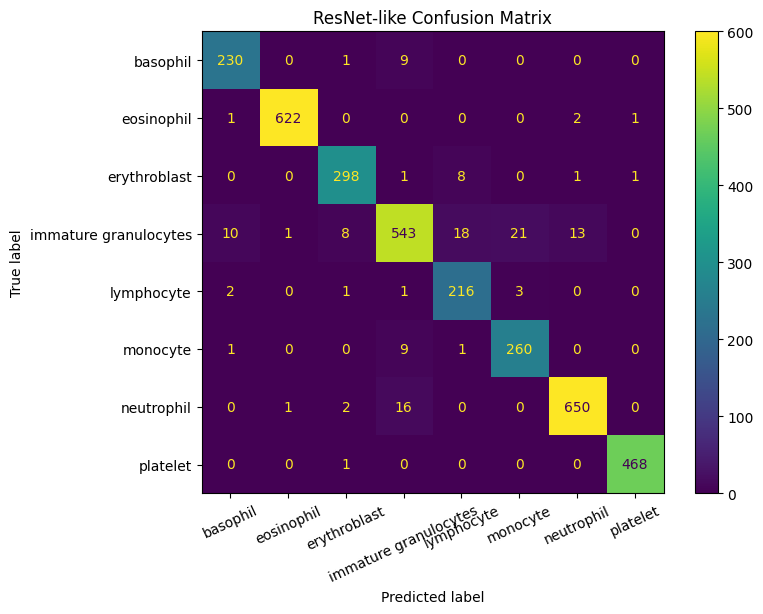

In [36]:
model_summary(X_test, y_test, y_pred, labels, "ResNet-like", "ResNet_CM")

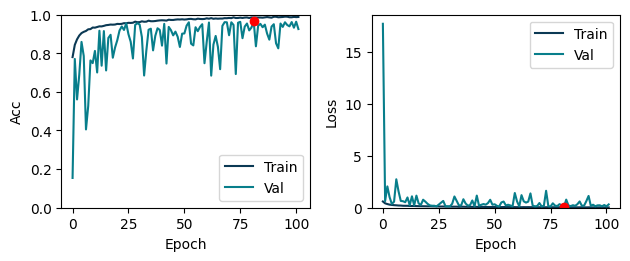

In [37]:
plot_metrics(history_.history_)
plt.savefig('./Report/png/ResNet_history.png')
plt.show()

In [50]:
p = ['initial_kernel', 'initial_n_filters',
     'initial_max_pooling',
     'final_dense',
     'n_res_blocks', 'n_layers_per_block',
     'optimizer', 'activation', 'use_augmentation']
filtered_best_params = {k: best_params[k] for k in p}
resnet_for_plot = make_ResNet(**filtered_best_params)
plot_model(model=resnet_for_plot, name='ResNet_model', dpi=60)

AttributeError: module 'pydot' has no attribute 'InvocationException'

In [ ]:
resnet_for_plot.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 28, 28, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 30, 30, 3) │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip         │ (None, 30, 30, 3) │          0 │ zero_padding2d_1… │
│ (RandomFlip)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation     │ (None, 30, 30, 3) │          0 │ random_flip[0][0] │
│ (RandomRotation)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 30, 30,    │      1,792 │ random_rotation[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 30,    │        256 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 30, 30,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 15, 15,    │     73,856 │ activation_7[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        512 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 15, 15,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 15, 15,    │    147,584 │ activation_8[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        512 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 15, 15,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 15, 15,    │    147,584 │ activation_9[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        512 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 15, 15,    │      8,320 │ activation_7[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 15, 15,    │          0 │ batch_normalizat

 Total params: 1,960,200 (7.48 MB)

 Trainable params: 1,957,768 (7.47 MB)

 Non-trainable params: 2,432 (9.50 KB)

In [39]:
save_model(name="ResNet", model=resnet)

In [40]:
def get_ranks(data):
    ranks = []
    for inner_list in data:
        sorted_list = sorted(inner_list, reverse=True)
        rank_dict = {val: i for i, val in enumerate(sorted_list)}
        ranks.append([rank_dict[val] for val in inner_list])
    return ranks

def rank_histogram(model, X_test, y_test):
    probas = model.predict_proba(X_test)
    all_ranks = get_ranks(probas)
    true_rank = [r[y] for (r,y) in zip(all_ranks,y_test)]
    rank_count = [true_rank.count(i) for i in range(len(labels))]
    rank_count_pc = [c/sum(rank_count)*100 for c in rank_count]
    create_bar_plot(labels=range(2,len(labels)+1),
                values=rank_count_pc[1:],
                axis_label="Frequency [%]",
                title=f"ResNet-like: Rank of Failed Test Samples")

107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


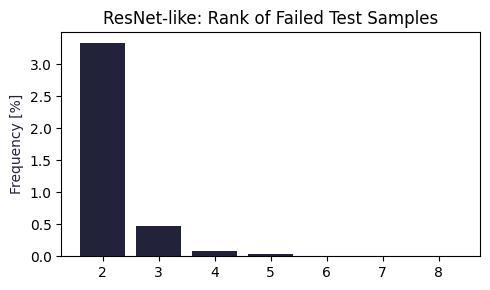

In [41]:
rank_histogram(resnet, X_test, y_test)
plt.savefig("./Report/png/ResNet_rank.png")
plt.show()

In [42]:
def get_rank(y_prob, y_true):
    return len(y_prob) - sorted(y_prob).index(y_prob[y_true])

def get_results(model, x, y_true):
    y_prob = model.predict_proba([x])
    y_pred = list(y_prob).index(max(y_prob))

    return {
        'y_true': y_true,
        'y_pred': y_pred,
        'fail': y_pred!=y_true,
        'rank': get_rank(y_prob, y_true),
        'proba': y_prob,
        'delta_proba': y_prob[y_pred] - y_prob[y_true]
    }

In [43]:
def create_fail_panel(images, results, title=None):

    if len(images) != len(results):
        raise ValueError("Number of images and labels must be equal.")

    rows = len(images)
    fig, axes = plt.subplots(rows, 2, figsize=(5, rows * 2))

    for i, result in enumerate(results):
        ax0 = axes[i, 0]
        ax0.imshow(images[i])
        ax0.set_title(f'True class: {result["y_true"]}')
        ax0.axis('off')

        ax1 = axes[i, 1]
        ax1.bar(
            range(len(labels)),
            result['proba'])

        ax1.set_title(f'True rank: {result["rank"]}')
        ax1.set_xlabel('Class')
        ax1.set_ylabel('Probability')
        ax1.set_xticks(range(len(labels)))
        ax1.set_xticklabels(range(len(labels)), rotation=0)

    if title is not None:
        fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    return fig

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


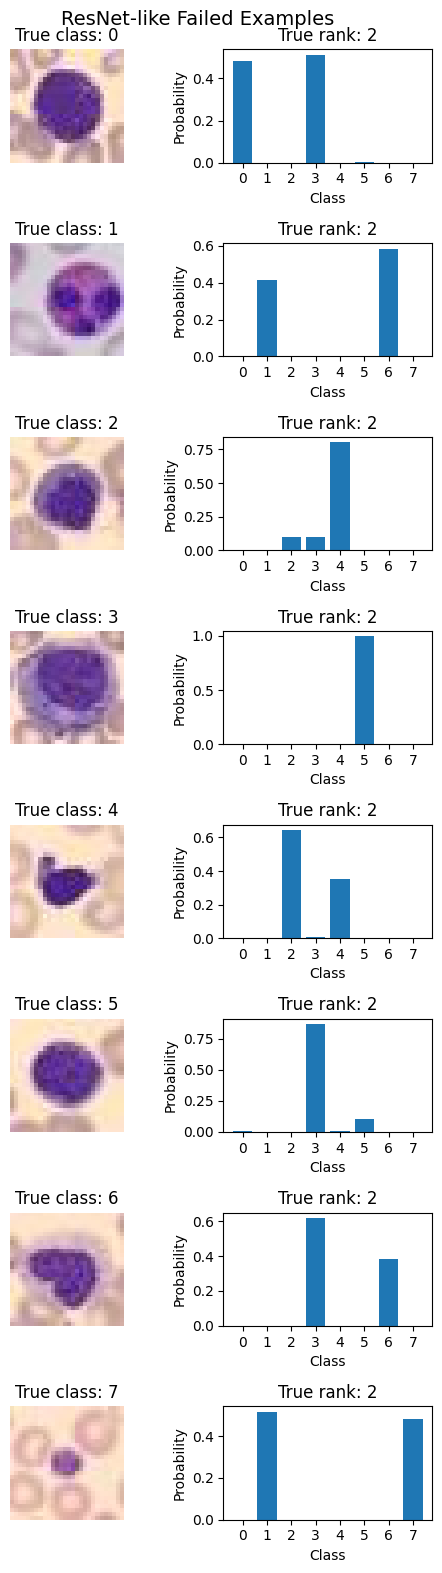

In [44]:
fail = y_pred != y_test

images = []
results = []
for i in range(len(labels)):
    if sum(y_test[fail]==i) > 0:
        x = X_test[fail][y_test[fail]==i][0]
        y_true = y_test[fail][y_test[fail]==i][0]

        results.append(get_results(
            model=resnet,
            x = x,
            y_true = y_true))
        images.append(x)

create_fail_panel(images=images, results=results, title="ResNet-like Failed Examples")
plt.savefig('./Report/png/ResNet_fails.png')
plt.show()